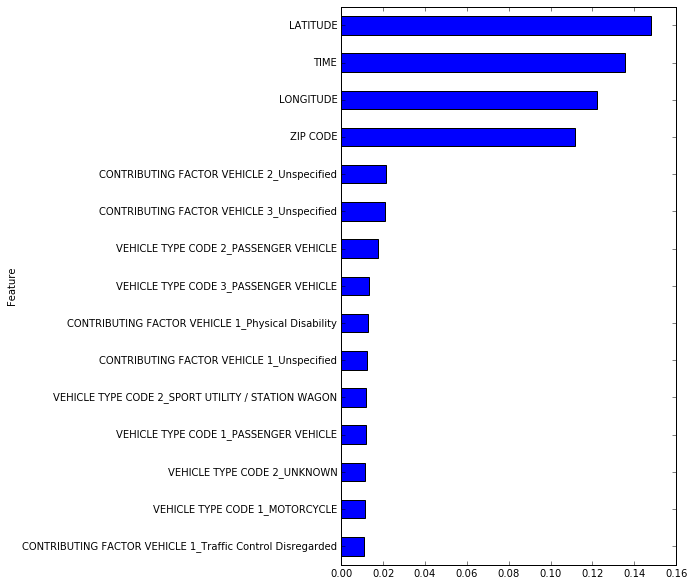

In [1]:
# Import required modules #

import os 
import pandas as pd
import numpy as np
import xgboost as xgb
import re
from matplotlib import pylab as plt
from sklearn.cross_validation import train_test_split

# read the data and perform manipulations #

os.getcwd()
os.chdir("C:/Users/shant/Desktop/Data Incubator")
data = pd.read_csv("NYPD_Motor_Vehicle_Collisions.csv")
pd.set_option('display.max_columns', None)
drops = np.r_[0, 6:18, 23]
data2 = data.drop(data.columns[drops], axis=1)
times = pd.DatetimeIndex(data['TIME'])
data2['TIME'] = times.hour*3600 + times.minute*60
data2['Casualties'] = data.iloc[:,10:11].sum(axis = 1)
data_cas = data2[data2['Casualties'] != 0]
data_nocas = data2[data2['Casualties'] == 0]

# Perform Oversampling for better Predictive Power #

from sklearn.cross_validation import train_test_split
splits = train_test_split(data_nocas, train_size=0.4, random_state=42)
data_nocas1 = splits[0]
data_comp = pd.concat((data_cas, data_nocas1), axis = 0)
data_comp2 = data_comp.iloc[np.random.permutation(len(data_comp['TIME']))]

# Prepare data for xgboost requirement #

comp = pd.get_dummies(data_comp2, dummy_na = False)
splits2 = train_test_split(comp, train_size=0.6, random_state=42)
train = splits2[0]
train2 = train.drop('Casualties', axis=1)
test = splits2[1]
test2 = test.drop('Casualties', axis=1)
trainM = train.drop('Casualties', axis=1).as_matrix()
testM = test.drop('Casualties', axis=1).as_matrix()

# Create labels #

pd.set_option('chained_assignment',None)
label = train['Casualties']
label2 = label
label2[label > 0] = 1
label2[label == 0] = 0
label2.reset_index(drop = True)
Obs = test['Casualties']
Obs2 = Obs
Obs2[Obs > 0] = 1
Obs2[Obs == 0] = 0
Obs2.reset_index(drop = True)

# Define parameters and run xgboost #

param = {'objective':'multi:softprob', 'eta': 0.1, 'silent':0, 'num_class':2, 'eval_metric':'mlogloss', 'subsample':0.5,
        'colsample_bytree':0.5, 'max_depth':6, 'min_child_weight':1, 'nfold':5}

param2 = {'objective':'multi:softprob', 'eta': 0.1, 'silent':0, 'num_class':2, 'eval_metric':'mlogloss', 'subsample':0.5,
        'colsample_bytree':0.5, 'max_depth':6, 'min_child_weight':1}

num_round = 100
xg_train = xgb.DMatrix(trainM, label=label2)
xg_test = xgb.DMatrix(testM)
bst = xgb.cv(param, xg_train, num_round)
bst = xgb.train(param2, xg_train, num_round)

# Perform Predictions and shape it into desired format #

pred = bst.predict(xg_test)
pred2 = pd.DataFrame(pred)
pred2['Observed'] = Obs2

# Determine Error #

error = np.mean((pred2.iloc[:,1] > 0.5).astype(int) != pred2.iloc[:,2])

# Find out important features #

importance = bst.get_fscore()
imp = pd.DataFrame(importance.items(), columns = ['Feature','Score'])
k = imp.iloc[:,0]
def stringer(string1):
    return int(re.search(r'\d+', string1).group())
k2 = np.array(map(stringer, k))
names = train2.columns.values
features = names[k2]
imp['Score'] = imp['Score'] / imp['Score'].sum()
imp['Feature'] = features
imp = imp.sort_values(by = 'Score', ascending = False).reset_index(drop = True)

# Plot the most useful features #

%matplotlib inline
ax = imp.iloc[0:15,:].plot(kind='barh', x='Feature', y='Score', legend=False, figsize = (6, 10))
ax.invert_yaxis()